# **Stroke Prediction Dataset analysis**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

In [ ]:
data_folder = './Data/'
patients = pd.read_csv(data_folder + 'healthcare-dataset-stroke-data.csv')
patients.head(5)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
patients = patients.drop(columns = ['id'])
patients = patients[(patients["gender"] == 'Male') | (patients["gender"] == 'Female')]  #izbaci other gender
patients = patients.dropna(subset=['bmi'])

#izbaci unknown iz smoking status i zamijeni vrijednosti proporcionalno ostalima
unknownSmoking = patients[patients['smoking_status'] == 'Unknown']['smoking_status'].values
uniqueSmoking, countsSmoking = np.unique(patients[patients['smoking_status'] != 'Unknown']['smoking_status'].values, return_counts=1)
patients.loc[patients['smoking_status'] == 'Unknown', 'smoking_status'] = np.random.choice(uniqueSmoking, len(unknownSmoking), p=countsSmoking / countsSmoking.sum())

patients.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [ ]:
#izdvojiti po 5% redom vrijednosti stupaca glucose level, bmi i mozda age
patientsForIntervals = patients.drop(patients.index[[1, 10, 300, 700, 900, 1100, 1300, 1500]]) #izbaciti random da bude djeljivo s 20, da se moze splitat na po 20

ageSorted = patientsForIntervals['age'].sort_values().copy()
ageBins = np.split(ageSorted.array,20);

bmiSorted = patientsForIntervals['bmi'].sort_values().copy()
bmiBins = np.split(bmiSorted.array,20);

glucoseSorted = patientsForIntervals['avg_glucose_level'].sort_values().copy()
glucoseBins = np.split(glucoseSorted.array,20);


In [ ]:
age5percent=[]
bmi5percent=[]
glucose5percent=[]

for i in range(0,20):
  age5percent.append(ageBins[i][-1])
  bmi5percent.append(bmiBins[i][-1])
  glucose5percent.append(glucoseBins[i][-1])

print(age5percent)
print(bmi5percent)
print(glucose5percent)


[4.0, 10.0, 16.0, 20.0, 25.0, 29.0, 33.0, 37.0, 41.0, 44.0, 48.0, 51.0, 54.0, 57.0, 60.0, 64.0, 69.0, 74.0, 79.0, 82.0]
[17.6, 19.7, 21.2, 22.5, 23.5, 24.5, 25.5, 26.4, 27.2, 28.0, 28.9, 29.8, 30.8, 31.9, 33.1, 34.5, 36.3, 38.9, 42.9, 97.6]
[60.6, 65.61, 69.94, 73.65, 77.06, 79.89, 82.61, 85.37, 88.52, 91.68, 94.88, 98.52, 102.87, 108.03, 113.57, 123.15, 141.84, 187.22, 214.73, 271.74]


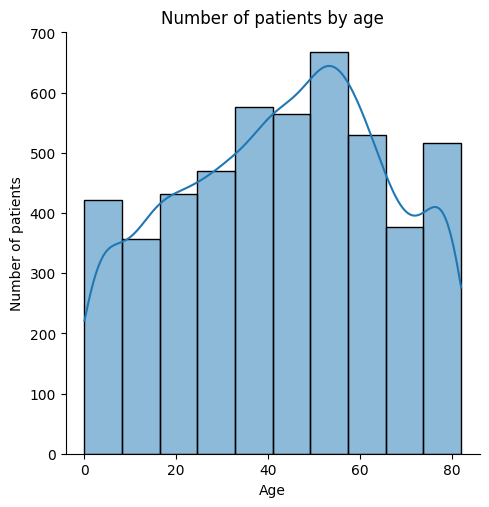

In [ ]:
ax = sns.displot(patients['age'], kde=True, bins=10)
ax.set(xlabel='Age',
       ylabel='Number of patients',
       title='Number of patients by age')

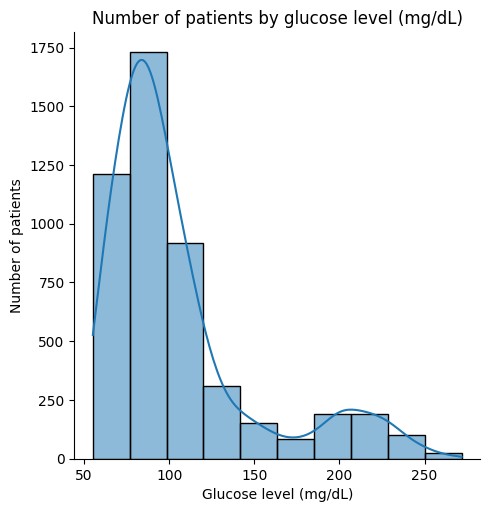

In [ ]:
ax = sns.displot(patients['avg_glucose_level'], kde=True, bins=10)
ax.set(xlabel='Glucose level (mg/dL)',
       ylabel='Number of patients',
       title='Number of patients by glucose level (mg/dL)')

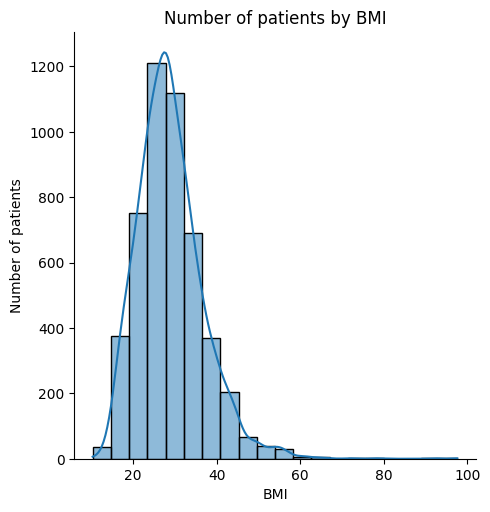

In [ ]:
ax = sns.displot(patients['bmi'], kde=True, bins=20)
ax.set(xlabel='BMI',
       ylabel='Number of patients',
       title='Number of patients by BMI')

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Number of patients'),
 Text(0.5, 1.0, 'Number of patients who had stroke by smoking status')]

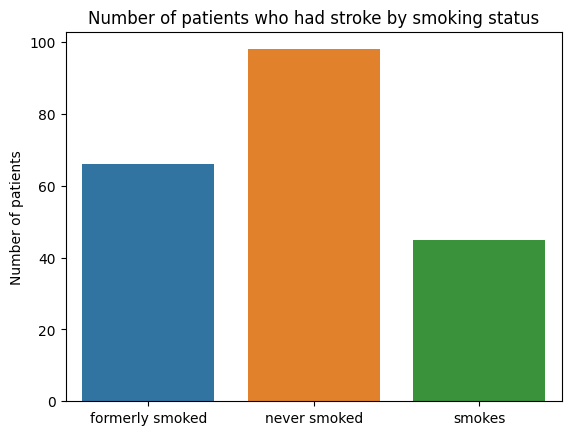

In [ ]:
strokeBySmoking=patients[patients['stroke'] == 1].groupby('smoking_status').agg({'stroke':'count'}).reset_index()
ax = sns.barplot(x='smoking_status', y = 'stroke', data=strokeBySmoking)
ax.set(xlabel='',
       ylabel='Number of patients',
       title='Number of patients who had stroke by smoking status')

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Number of patients'),
 Text(0.5, 1.0, "Number of patients who didn't have stroke by smoking status")]

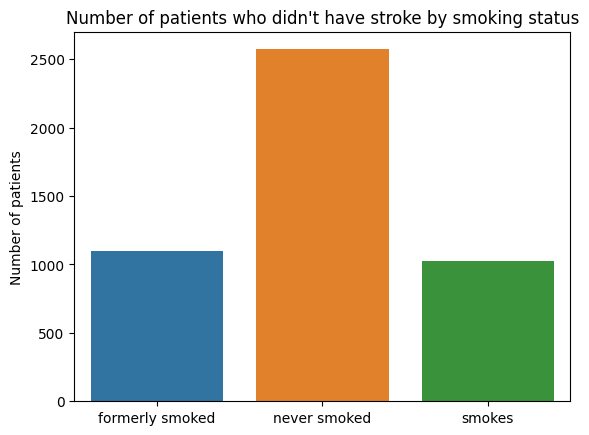

In [ ]:
noStrokeBySmoking=patients[patients['stroke'] == 0].groupby('smoking_status').agg({'stroke':'count'}).reset_index()
ax = sns.barplot(x='smoking_status', y = 'stroke', data=noStrokeBySmoking)
ax.set(xlabel='',
       ylabel='Number of patients',
       title='Number of patients who didn\'t have stroke by smoking status')

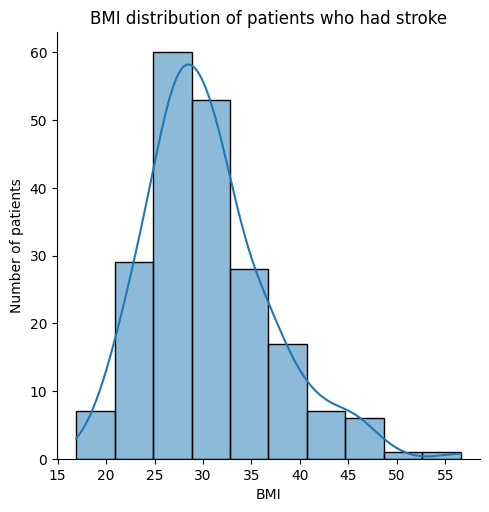

In [ ]:
bmiWithStroke = patients[patients['stroke'] == 1]['bmi']
ax = sns.displot(bmiWithStroke, kde=True, bins=10)
ax.set(xlabel='BMI',
       ylabel='Number of patients',
       title='BMI distribution of patients who had stroke')

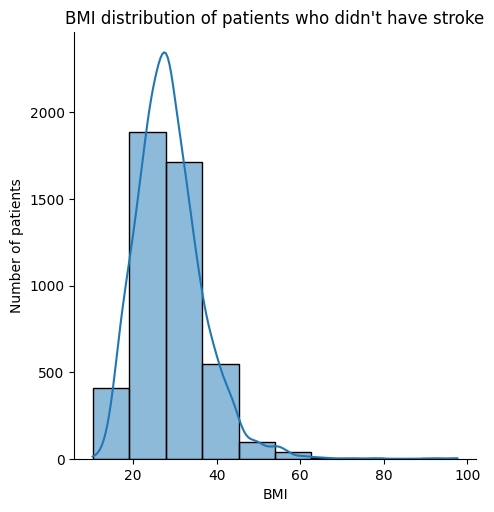

In [ ]:
bmiWithoutStroke = patients[patients['stroke'] == 0]['bmi']
ax = sns.displot(bmiWithoutStroke, kde=True, bins=10)
ax.set(xlabel='BMI',
       ylabel='Number of patients',
       title='BMI distribution of patients who didn\'t have stroke')

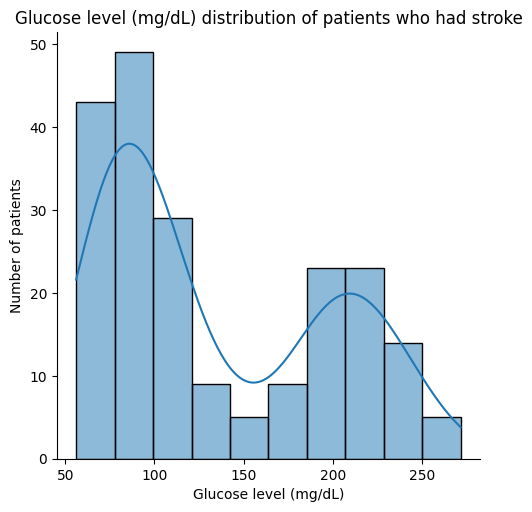

In [ ]:
glucoseWithStroke = patients[patients['stroke'] == 1]['avg_glucose_level']
ax = sns.displot(glucoseWithStroke, kde=True, bins=10)
ax.set(xlabel='Glucose level (mg/dL)',
       ylabel='Number of patients',
       title='Glucose level (mg/dL) distribution of patients who had stroke')

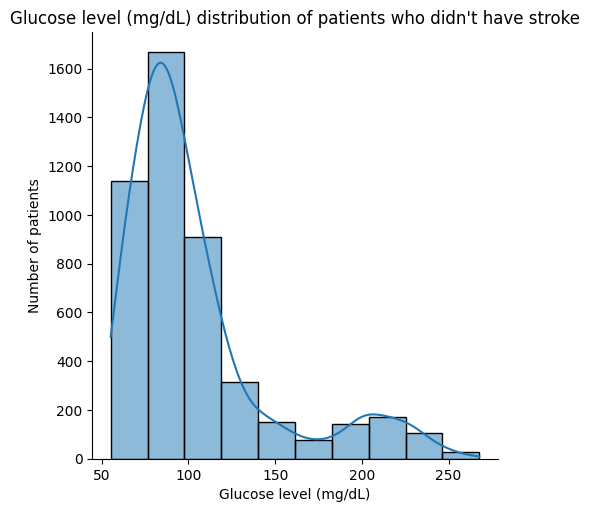

In [ ]:
glucoseWithoutStroke = patients[patients['stroke'] == 0]['avg_glucose_level']
ax = sns.displot(glucoseWithoutStroke, kde=True, bins=10)
ax.set(xlabel='Glucose level (mg/dL)',
       ylabel='Number of patients',
       title='Glucose level (mg/dL) distribution of patients who didn\'t have stroke')

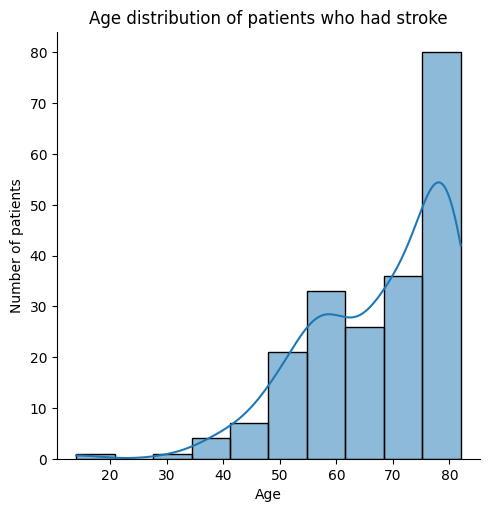

In [ ]:
ageWithStroke = patients[patients['stroke'] == 1]['age']
ax = sns.displot(ageWithStroke, kde=True, bins=10)
ax.set(xlabel='Age',
       ylabel='Number of patients',
       title='Age distribution of patients who had stroke')

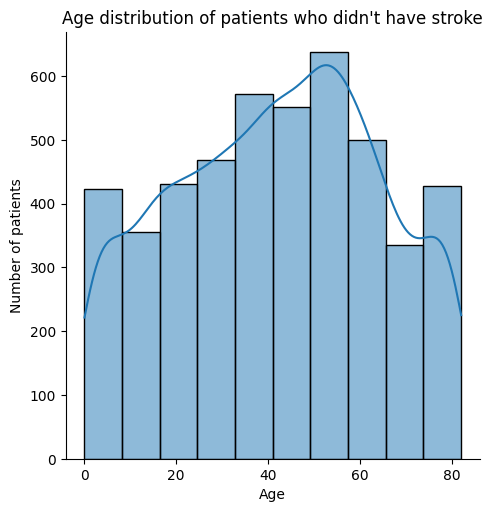

In [ ]:
ageWithoutStroke = patients[patients['stroke'] == 0]['age']
ax = sns.displot(ageWithoutStroke, kde=True, bins=10)
ax.set(xlabel='Age',
       ylabel='Number of patients',
       title='Age distribution of patients who didn\'t have stroke')

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Number of patients'),
 Text(0.5, 1.0, 'Number of patients who had stroke by gender')]

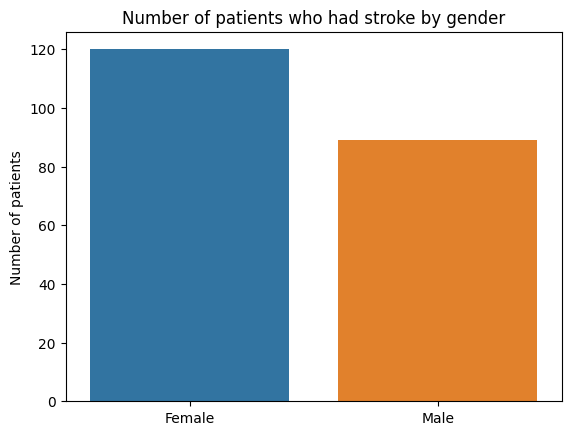

In [ ]:
strokeByGender=patients[patients['stroke'] == 1].groupby('gender').agg({'stroke':'count'}).reset_index()
ax = sns.barplot(x='gender', y = 'stroke', data=strokeByGender)
ax.set(xlabel='',
       ylabel='Number of patients',
       title='Number of patients who had stroke by gender')

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Number of patients'),
 Text(0.5, 1.0, "Number of patients who didn't have stroke by gender")]

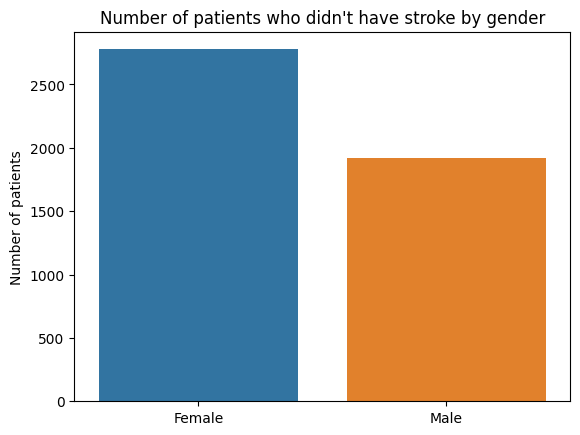

In [ ]:
noStrokeByGender=patients[patients['stroke'] == 0].groupby('gender').agg({'stroke':'count'}).reset_index()
ax = sns.barplot(x='gender', y = 'stroke', data=noStrokeByGender)
ax.set(xlabel='',
       ylabel='Number of patients',
       title='Number of patients who didn\'t have stroke by gender')

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Number of patients'),
 Text(0.5, 1.0, 'Number of patients who had stroke by hypertension')]

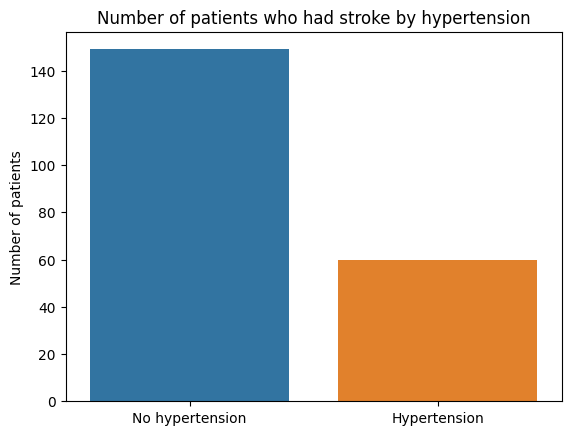

In [ ]:
strokeByHypertension=patients[patients['stroke'] == 1].groupby('hypertension').agg({'stroke':'count'}).reset_index()
strokeByHypertension['hypertension'] = strokeByHypertension['hypertension'].replace({0:'No hypertension', 1: 'Hypertension'})
ax = sns.barplot(x='hypertension', y = 'stroke', data=strokeByHypertension)
ax.set(xlabel='',
       ylabel='Number of patients',
       title='Number of patients who had stroke by hypertension')

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Number of patients'),
 Text(0.5, 1.0, "Number of patients who didn't have stroke by hypertension")]

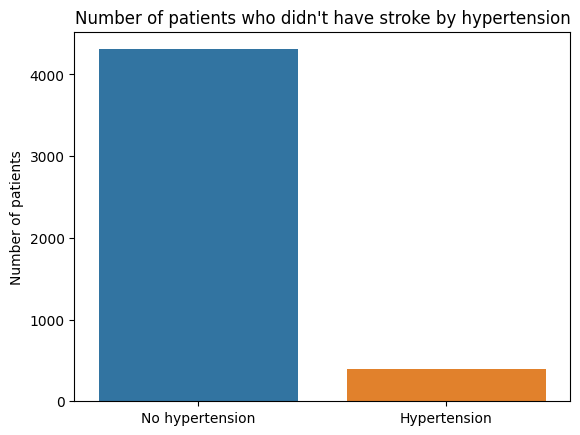

In [ ]:
noStrokeByHypertension=patients[patients['stroke'] == 0].groupby('hypertension').agg({'stroke':'count'}).reset_index()
noStrokeByHypertension['hypertension'] = noStrokeByHypertension['hypertension'].replace({0:'No hypertension', 1: 'Hypertension'})
ax = sns.barplot(x='hypertension', y = 'stroke', data=noStrokeByHypertension)
ax.set(xlabel='',
       ylabel='Number of patients',
       title='Number of patients who didn\'t have stroke by hypertension')

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Number of patients'),
 Text(0.5, 1.0, 'Number of patients who had stroke by heart disease')]

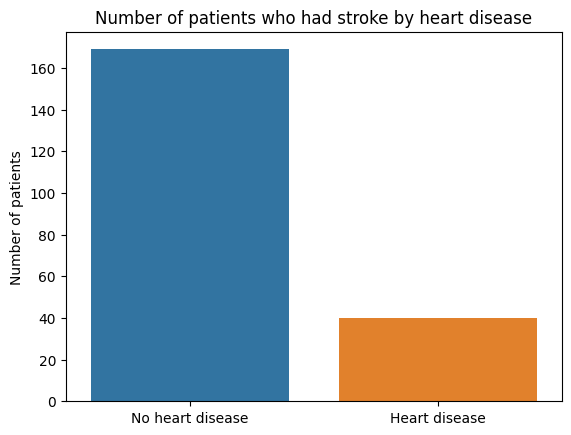

In [ ]:
strokeByHeartDisease=patients[patients['stroke'] == 1].groupby('heart_disease').agg({'stroke':'count'}).reset_index()
strokeByHeartDisease['heart_disease'] = strokeByHeartDisease['heart_disease'].replace({0:'No heart disease', 1: 'Heart disease'})
ax = sns.barplot(x='heart_disease', y = 'stroke', data=strokeByHeartDisease)
ax.set(xlabel='',
       ylabel='Number of patients',
       title='Number of patients who had stroke by heart disease')

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Number of patients'),
 Text(0.5, 1.0, "Number of patients who didn't have stroke by heart disease")]

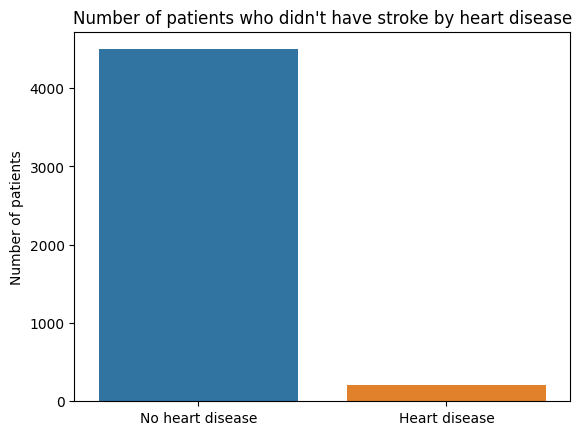

In [ ]:
noStrokeByHeartDisease=patients[patients['stroke'] == 0].groupby('heart_disease').agg({'stroke':'count'}).reset_index()
noStrokeByHeartDisease['heart_disease'] = noStrokeByHeartDisease['heart_disease'].replace({0:'No heart disease', 1: 'Heart disease'})
ax = sns.barplot(x='heart_disease', y = 'stroke', data=noStrokeByHeartDisease)
ax.set(xlabel='',
       ylabel='Number of patients',
       title='Number of patients who didn\'t have stroke by heart disease')

In [ ]:
categorical_cols = ['work_type','Residence_type','smoking_status']
for i in range(len(categorical_cols)):
  ohe = OneHotEncoder()
  transformed = ohe.fit_transform(patients[[categorical_cols[i]]])
  patients[ohe.categories_[0]]=transformed.toarray()
patients.drop(columns=categorical_cols, inplace=True)
patients['ever_married'] = patients['ever_married'].replace({'No': 0, 'Yes': 1})
patients['gender'] = patients['gender'].replace({'Male': 1, 'Female': 0})

In [ ]:
patients.head(5)

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,Govt_job,Never_worked,Private,Self-employed,children,Rural,Urban,formerly smoked,never smoked,smokes
0,1,67.0,0,1,1,228.69,36.6,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1,80.0,0,1,1,105.92,32.5,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,49.0,0,0,1,171.23,34.4,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0,79.0,1,0,1,174.12,24.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5,1,81.0,0,0,1,186.21,29.0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [ ]:
sc=MinMaxScaler()
numeric_cols = ['age','avg_glucose_level','bmi']
patients[numeric_cols]=sc.fit_transform(patients[numeric_cols])

In [ ]:
oversample = RandomOverSampler(sampling_strategy=0.3)
X=patients.drop(columns=['stroke']).copy()
y=patients['stroke'].copy()
X_oversampled, y_oversampled = oversample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.2)
param_grid_dt = {'max_depth': [3,4,5,6,7,8]}
param_grid_svm = {'C': [0.1, 0.5, 1, 1.5, 2], 'gamma': [0.1, 0.5, 1, 1.5, 2], 'kernel': ['linear', 'rbf']}
param_grid_knn = {'n_neighbors': [3,4,5,6,7,8]}
param_grid_logReg = {'C': [0.1, 0.3, 0.5, 1, 2]}

In [ ]:
#spremi pripremljeni dataset u csv
patientsForTraining = X_oversampled.copy()
patientsForTraining.insert(17, "Stroke", y_oversampled, True)
patientsForTraining.to_csv(data_folder + "healthcare-dataset-stroke-data-cleaned-oversampled.csv", index=False)

In [ ]:
svc=SVC()
dTree=DecisionTreeClassifier()
knn=KNeighborsClassifier()
logReg=LogisticRegression(max_iter=1000)

clf_svc = GridSearchCV(svc, param_grid_svm, scoring='recall', cv=5)
clf_svc.fit(X_train, y_train)
print("SVC na testu: ", accuracy_score(y_test, clf_svc.predict(X_test)))
print("Najbolji parameter: ", clf_svc.best_params_)

clf_dTree = GridSearchCV(dTree, param_grid_dt, scoring='recall', cv=5)
clf_dTree.fit(X_train, y_train)
print("Tree na testu: ", accuracy_score(y_test, clf_dTree.predict(X_test)))
print("Najbolji parameter: ", clf_dTree.best_params_)

clf_knn = GridSearchCV(knn, param_grid_knn, scoring='recall', cv=5)
clf_knn.fit(X_train, y_train)
print("KNN na testu: ", accuracy_score(y_test, clf_knn.predict(X_test)))
print("Najbolji parameter: ", clf_knn.best_params_)

clf_logReg = GridSearchCV(logReg, param_grid_logReg, scoring='recall', cv=5)
clf_logReg.fit(X_train, y_train)
print("LogReg na testu: ", accuracy_score(y_test, clf_logReg.predict(X_test)))
print("Najbolji parameter: ", clf_logReg.best_params_)

SVC na testu:  0.869885433715221
Najbolji parameter:  {'C': 2, 'gamma': 2, 'kernel': 'rbf'}
Tree na testu:  0.8846153846153846
Najbolji parameter:  {'max_depth': 8}
KNN na testu:  0.9312602291325696
Najbolji parameter:  {'n_neighbors': 3}
LogReg na testu:  0.8036006546644845
Najbolji parameter:  {'C': 2}


KNN na testu:  0.9312602291325696


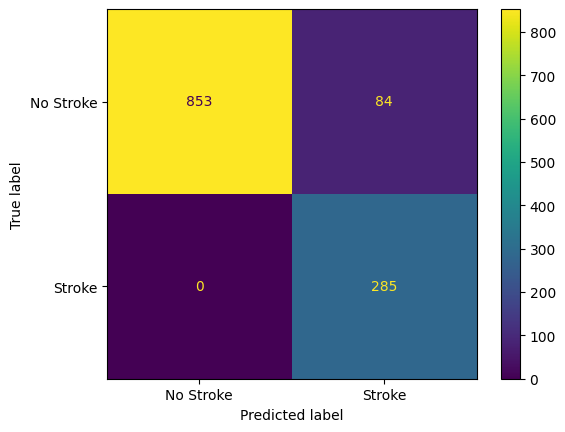

In [ ]:
#za knn, odabran kao najbolji
y_test_prediction = clf_knn.predict(X_test)
cm = confusion_matrix(y_test, y_test_prediction)
print("KNN na testu: ", accuracy_score(y_test, y_test_prediction))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Stroke', 'Stroke'])
disp.plot()

KNN na testu:  0.9582484725050916


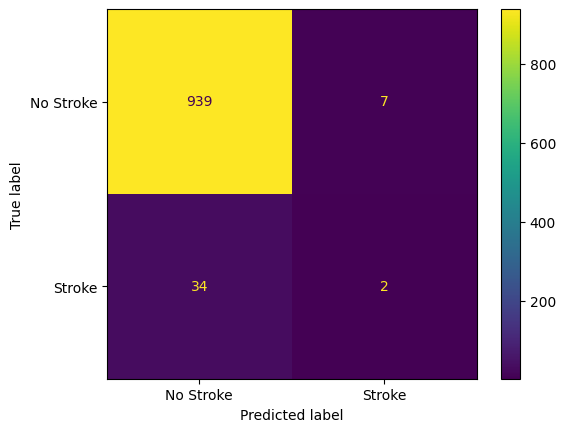

In [ ]:
#za knn, losa matrica konfuzije, bez oversamplea, nebalansiran skup

knn_bad = KNeighborsClassifier(n_neighbors = 3);
X_train_bad, X_test_bad, y_train_bad, y_test_bad = train_test_split(X, y, test_size=0.2)
knn_bad.fit(X_train_bad, y_train_bad)
y_test_bad_prediction = knn_bad.predict(X_test_bad)
print("KNN na testu: ", accuracy_score(y_test_bad, y_test_bad_prediction))
cm = confusion_matrix(y_test_bad, y_test_bad_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Stroke', 'Stroke'])
disp.plot()

Odabrane kategoričke značajke: 
['gender' 'hypertension' 'heart_disease' 'ever_married' 'Govt_job'
 'Never_worked' 'Private' 'Self-employed' 'children' 'Rural' 'Urban'
 'formerly smoked' 'never smoked' 'smokes']
Odabrane kontinuirane značajke: 
['age' 'avg_glucose_level' 'bmi']


<BarContainer object of 3 artists>

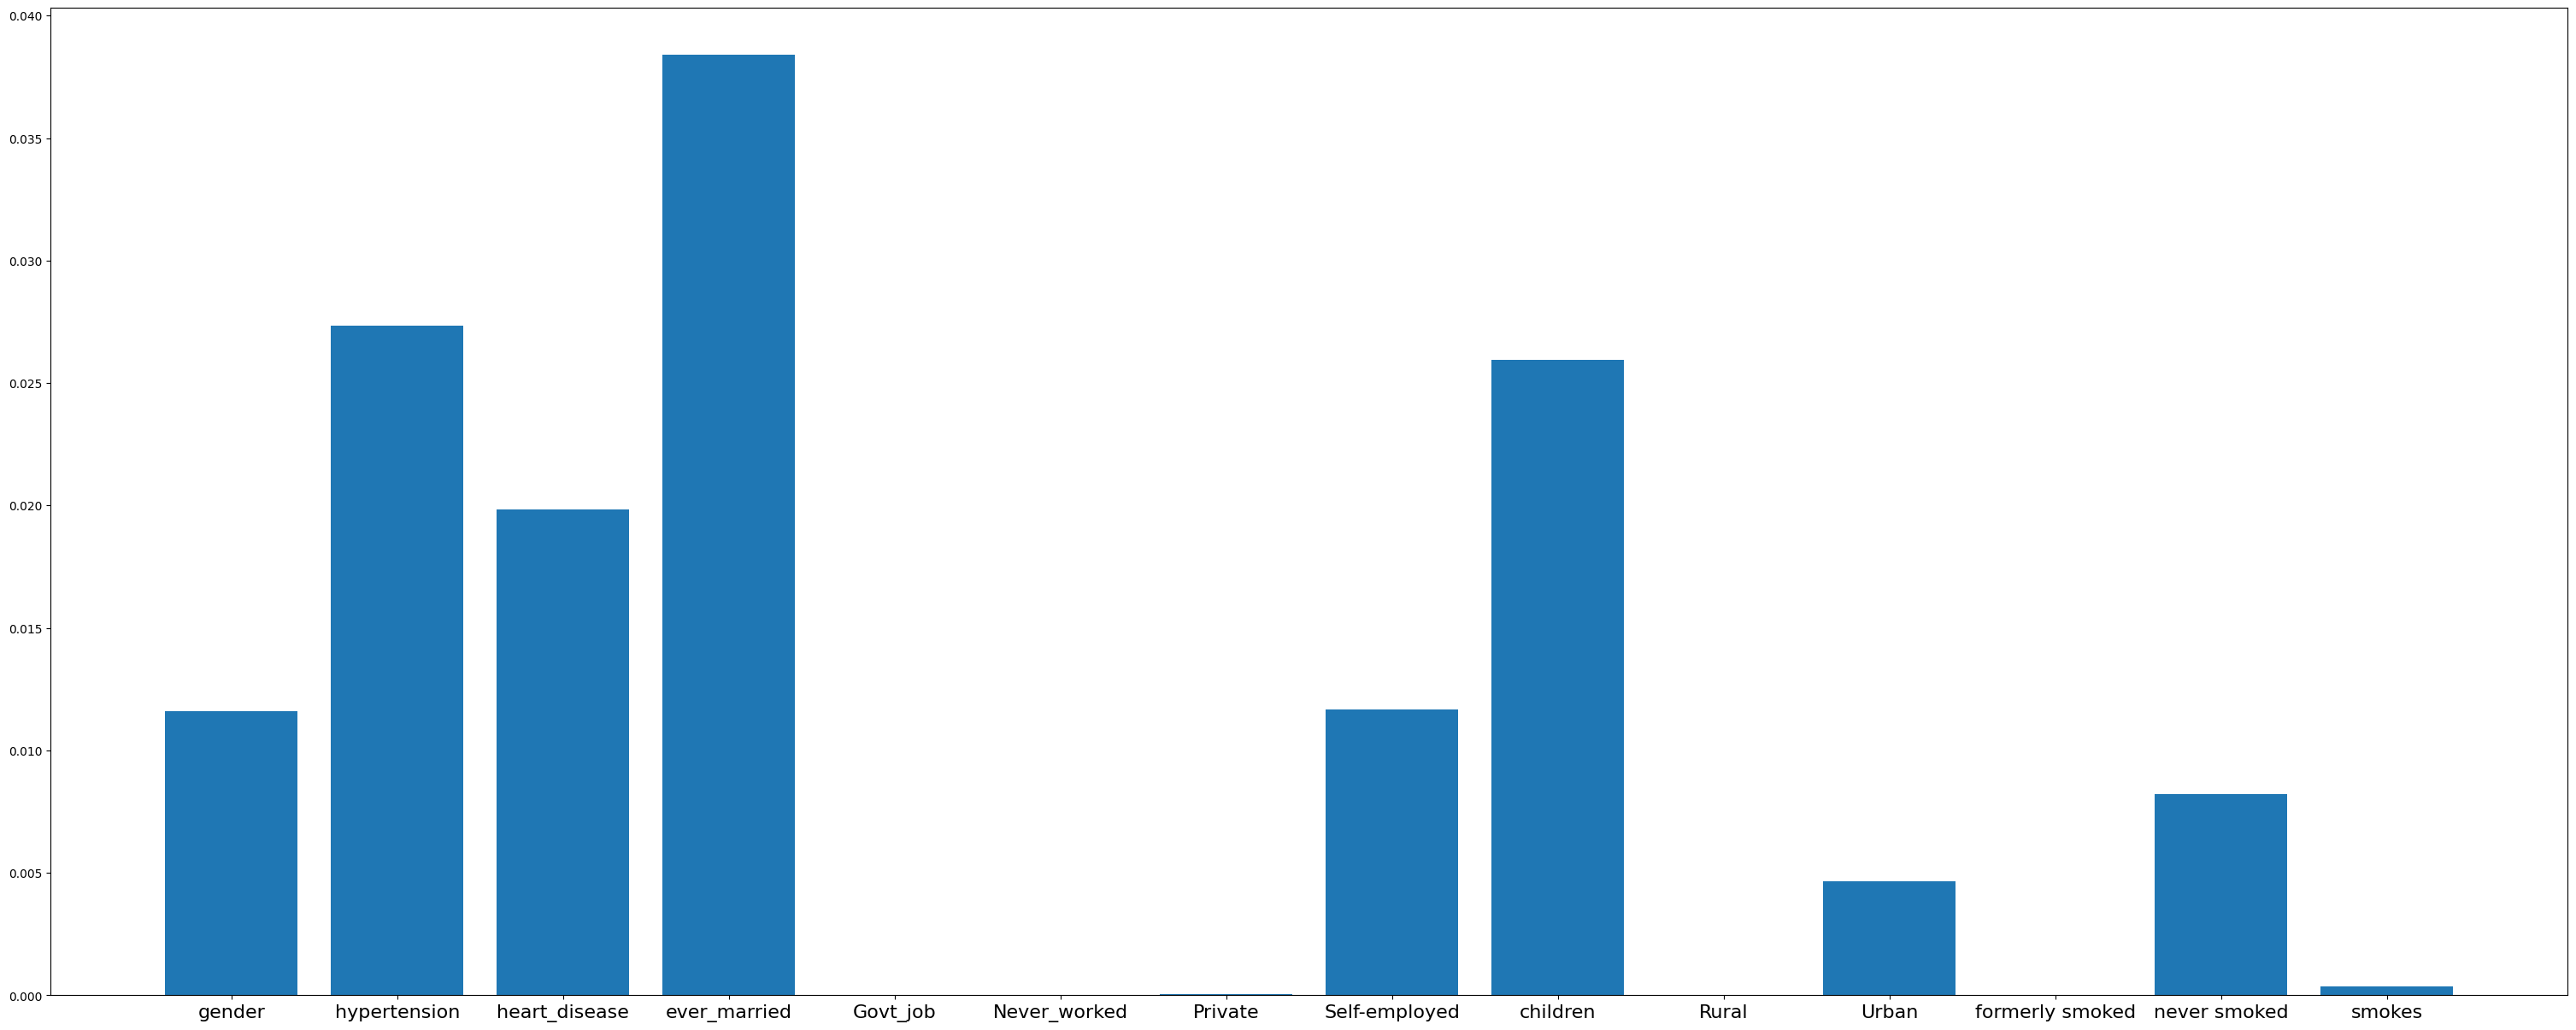

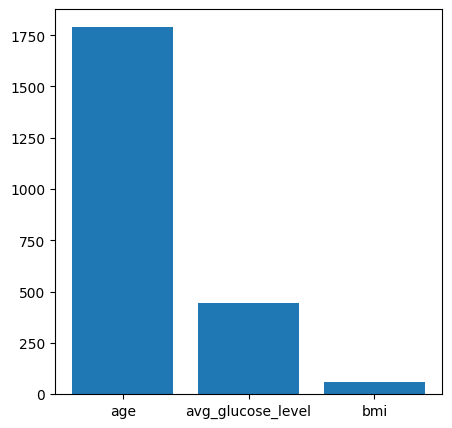

In [32]:
#filtri
skb_categorical = SelectKBest(mutual_info_classif, k=14)
X_categorical = X_oversampled.drop(columns=numeric_cols).copy()
X_new_categorical = skb_categorical.fit_transform(X_categorical,y_oversampled)
print("Odabrane kategoričke značajke: ")
print(skb_categorical.get_feature_names_out())

skb_numeric = SelectKBest(f_classif, k=3)
X_numeric = X_oversampled[numeric_cols].copy()
X_new_numeric = skb_numeric.fit_transform(X_numeric,y_oversampled)
print("Odabrane kontinuirane značajke: ")
print(skb_numeric.get_feature_names_out())

fig, ax = plt.subplots(figsize=(38,15))
ax.tick_params(axis='x', labelsize=16)
plt.bar(X_categorical.columns, skb_categorical.scores_)

plt.figure(figsize=(5,5))
plt.bar(X_numeric.columns, skb_numeric.scores_)